In [89]:
import polars as pl
# 列表示を省略しない
pl.Config.set_tbl_cols(-1)
# 行の表示を省略しない
pl.Config.set_tbl_rows(-1)
# df.selectで使用するExpr
import polars.selectors as cs

# 4章 顧客の全体像を把握する１０本ノック

引き続き、スポーツジムの会員データを使って顧客の行動を分析していきます。  
３章で顧客の全体像を把握しました。  
ここからは、機械学習を用いて顧客のグループ化や顧客の利用予測行なっていきましょう。  
ここでは、教師なし学習、教師あり学習の回帰を取り扱います。

### ノック31：データを読み込んで確認しよう

In [90]:
uselog = pl.read_csv('use_log.csv')
uselog.null_count()

log_id,customer_id,usedate
u32,u32,u32
0,0,0


In [91]:
customer = pl.read_csv('customer_join.csv')
customer.null_count().transpose(include_header = True)

column,column_0
str,u32
"""customer_id""",0
"""name""",0
"""class""",0
"""gender""",0
"""start_date""",0
"""end_date""",2842
"""campaign_id""",0
"""is_deleted""",0
"""class_name""",0


### ノック32：クラスタリングで顧客をグループ化しよう

In [92]:
customer_clustering = customer[["mean", "median","max", "min", "membership_period"]]
customer_clustering.head()

mean,median,max,min,membership_period
f64,f64,i64,i64,i64
4.833333,5.0,8,2,47
5.083333,5.0,7,3,47
4.583333,5.0,6,3,47
4.833333,4.5,7,2,47
3.916667,4.0,6,1,47


In [93]:
# Scikit-Learnはpolarsとの連携が不十分なので、
# DataFrameをpandasに変換する
customer_clustering_pandas = customer_clustering.to_pandas()


# 利用回数などでクラスタリングを行う
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
customer_clustering_sc = sc.fit_transform(customer_clustering_pandas)

kmeans = KMeans(n_clusters=4, random_state=0)
clusters = kmeans.fit(customer_clustering_sc)
customer_clustering_pandas = customer_clustering_pandas.assign(cluster = clusters.labels_)

print(customer_clustering_pandas["cluster"].unique())
display(customer_clustering_pandas.head())


# 計算結果をpolarsに再変換する
customer_clustering = pl.DataFrame(customer_clustering_pandas)

[3 2 0 1]


c:\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


,mean,median,max,min,membership_period,cluster
0,4.833333,5.0,8,2,47,3
1,5.083333,5.0,7,3,47,3
2,4.583333,5.0,6,3,47,3
3,4.833333,4.5,7,2,47,3
4,3.916667,4.0,6,1,47,3


### ノック33：クラスタリング結果を分析しよう

In [94]:
customer_clustering.columns = ["月内平均値","月内中央値", "月内最大値", "月内最小値","会員期間", "cluster"]
(
    customer_clustering
    .group_by("cluster")
    .agg([pl.count("月内平均値"),
          pl.count("月内中央値"),
          pl.count("月内最大値"),
          pl.count("月内最小値"),
          pl.count("会員期間")])
    .sort(by = "cluster")
)

cluster,月内平均値,月内中央値,月内最大値,月内最小値,会員期間
i32,u32,u32,u32,u32,u32
0,1334,1334,1334,1334,1334
1,846,846,846,846,846
2,763,763,763,763,763
3,1249,1249,1249,1249,1249


In [95]:
customer_clustering.group_by("cluster").mean().sort(by = "cluster")

cluster,月内平均値,月内中央値,月内最大値,月内最小値,会員期間
i32,f64,f64,f64,f64,f64
0,5.524239,5.375187,8.745877,2.687406,14.843328
1,8.054608,8.039598,10.009456,6.160757,7.072104
2,3.054713,2.888598,4.756225,1.653997,9.263434
3,4.677494,4.671337,7.232986,2.153723,36.915933


### ノック34：クラスタリング結果を可視化してみよう

In [96]:
from sklearn.decomposition import PCA
X = customer_clustering_sc
pca = PCA(n_components=2)
pca.fit(X)
x_pca = pca.transform(X)

# 次元削減したnumpy.Arrayをpolars.DataFrameに再変換して、クラスター番号列を追加する
pca_df = pl.DataFrame(x_pca)
pca_df = (
    pca_df.with_columns(
        customer_clustering["cluster"]
    )
)

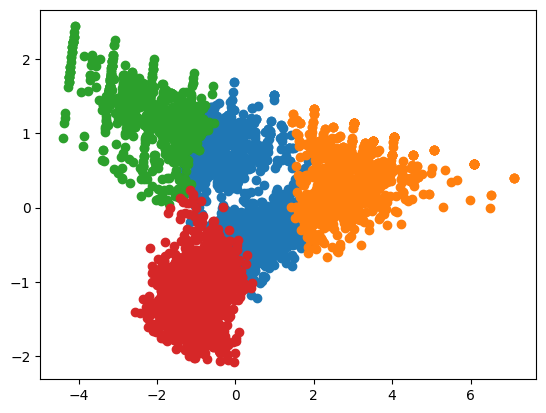

In [97]:
import matplotlib.pyplot as plt
%matplotlib inline
for i in customer_clustering["cluster"].unique():
    tmp = pca_df.filter( pl.col("cluster") == i )
    # numpy.Arrayをpolars.DataFrameに変換した場合の列名のデフォルトはcolumn_(数字)である
    plt.scatter(tmp["column_0"], tmp["column_1"])

### ノック35：クラスタリング結果をもとに退会顧客の傾向を把握しよう

In [98]:
customer_clustering = pl.concat(items = [customer_clustering, customer], how = "horizontal")
(
    customer_clustering
    .group_by(by = ["cluster", "is_deleted"])
    .agg( pl.count("customer_id") )
    .sort(by = ["cluster", "is_deleted"])
)

cluster,is_deleted,customer_id
i32,i64,u32
0,0,785
0,1,549
1,0,827
1,1,19
2,1,763
3,0,1230
3,1,19


In [99]:
(
    customer_clustering
    .group_by(["cluster", "routine_flg"])
    .agg([pl.count("customer_id")])
    .sort(by = "cluster")
)

cluster,routine_flg,customer_id
i32,i64,u32
0,1,1106
0,0,228
1,0,52
1,1,794
2,0,497
2,1,266
3,1,1247
3,0,2


### ノック36：翌月の利用回数予測を行うためのデータ準備をしよう

In [100]:
# ノック25と同じ
uselog = (
    uselog.with_columns(
        uselog["usedate"].str.to_datetime()
        .alias("usedate")
    )
)
uselog = (
    uselog.with_columns(
        uselog["usedate"]
        .dt.strftime("%Y%m")
        .alias("年月")
    )
)

uselog_months = (
    uselog
    .group_by(by = ["年月", "customer_id"])
    .agg( pl.count("log_id") )
    .sort(by = ["年月", "customer_id"])
)
uselog_months = (
    uselog_months.rename(mapping = {"log_id":"count"})
)

uselog_months.head()

年月,customer_id,count
str,str,u32
"""201804""","""AS002855""",4
"""201804""","""AS009013""",2
"""201804""","""AS009373""",3
"""201804""","""AS015315""",6
"""201804""","""AS015739""",7


In [101]:
# 雑な結合はpandasの方が簡単なので、pandasに変換する
import pandas as pd
uselog_months_pandas = uselog_months.to_pandas()

year_months = list(uselog_months_pandas["年月"].unique())
predict_data = pd.DataFrame()
for i in range(6, len(year_months)):
    tmp = uselog_months_pandas.loc[uselog_months_pandas["年月"]==year_months[i]].copy()
    tmp.rename(columns={"count":"count_pred"}, inplace=True)
    for j in range(1, 7):
        tmp_before = uselog_months_pandas.loc[uselog_months_pandas["年月"]==year_months[i-j]].copy()
        del tmp_before["年月"]
        tmp_before.rename(columns={"count":"count_{}".format(j-1)}, inplace=True)
        tmp = pd.merge(tmp, tmp_before, on="customer_id", how="left")
    predict_data = pd.concat([predict_data, tmp], ignore_index=True)
predict_data.head()

,年月,customer_id,count_pred,count_0,count_1,count_2,count_3,count_4,count_5
0,201810,AS002855,3,7.0,3.0,5.0,5.0,5.0,4.0
1,201810,AS008805,2,2.0,5.0,7.0,8.0,NaN,NaN
2,201810,AS009373,5,6.0,6.0,7.0,4.0,4.0,3.0
3,201810,AS015233,7,9.0,11.0,5.0,7.0,7.0,NaN
4,201810,AS015315,4,7.0,3.0,6.0,3.0,3.0,6.0


In [102]:
predict_data = predict_data.dropna()
predict_data = predict_data.reset_index(drop=True)
predict_data.head()

,年月,customer_id,count_pred,count_0,count_1,count_2,count_3,count_4,count_5
0,201810,AS002855,3,7.0,3.0,5.0,5.0,5.0,4.0
1,201810,AS009373,5,6.0,6.0,7.0,4.0,4.0,3.0
2,201810,AS015315,4,7.0,3.0,6.0,3.0,3.0,6.0
3,201810,AS015739,5,6.0,5.0,8.0,6.0,5.0,7.0
4,201810,AS019860,7,5.0,7.0,4.0,6.0,8.0,6.0


### ノック37：特徴となる変数を付与しよう

In [103]:
# ノック36から良い案が思いついていないので、一部をpandasに変換する
predict_data = pd.merge(predict_data, customer[["customer_id","start_date"]].to_pandas(), on="customer_id", how="left")
predict_data.head()

,年月,customer_id,count_pred,count_0,count_1,count_2,count_3,count_4,count_5,start_date
0,201810,AS002855,3,7.0,3.0,5.0,5.0,5.0,4.0,2016-11-01
1,201810,AS009373,5,6.0,6.0,7.0,4.0,4.0,3.0,2015-11-01
2,201810,AS015315,4,7.0,3.0,6.0,3.0,3.0,6.0,2015-07-01
3,201810,AS015739,5,6.0,5.0,8.0,6.0,5.0,7.0,2017-06-01
4,201810,AS019860,7,5.0,7.0,4.0,6.0,8.0,6.0,2017-10-01


In [104]:
# ノック36から良い案が思いついていないので、一部をpandasに変換する
predict_data["now_date"] = pd.to_datetime(predict_data["年月"], format="%Y%m")
predict_data["start_date"] = pd.to_datetime(predict_data["start_date"])
from dateutil.relativedelta import relativedelta
predict_data["period"] = None
for i in range(len(predict_data)):
    delta = relativedelta(predict_data.loc[i,"now_date"], predict_data.loc[i,"start_date"])
    predict_data.loc[i,"period"] = delta.years*12 + delta.months
predict_data.head()

,年月,customer_id,count_pred,count_0,count_1,count_2,count_3,count_4,count_5,start_date,now_date,period
0,201810,AS002855,3,7.0,3.0,5.0,5.0,5.0,4.0,2016-11-01,2018-10-01,23
1,201810,AS009373,5,6.0,6.0,7.0,4.0,4.0,3.0,2015-11-01,2018-10-01,35
2,201810,AS015315,4,7.0,3.0,6.0,3.0,3.0,6.0,2015-07-01,2018-10-01,39
3,201810,AS015739,5,6.0,5.0,8.0,6.0,5.0,7.0,2017-06-01,2018-10-01,16
4,201810,AS019860,7,5.0,7.0,4.0,6.0,8.0,6.0,2017-10-01,2018-10-01,12


### ノック38：来月の利用回数予測モデルを作成しよう

In [105]:
# pandas形式の利用
predict_data = predict_data.loc[predict_data["start_date"]>=pd.to_datetime("20180401")]
from sklearn import linear_model
import sklearn.model_selection
model = linear_model.LinearRegression()
X = predict_data[["count_0","count_1","count_2","count_3","count_4","count_5","period"]]
y = predict_data["count_pred"]
X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(X,y, random_state=0)
model.fit(X_train, y_train)

LinearRegression()

In [106]:
print(model.score(X_train, y_train))
print(model.score(X_test, y_test))

0.6111525903215709
0.5964633323568842


### ノック39：モデルに寄与している変数を確認しよう

In [107]:
# pandasで我慢
coef = pd.DataFrame({"feature_names":X.columns, "coefficient":model.coef_})
coef

,feature_names,coefficient
0,count_0,0.359133
1,count_1,0.181937
2,count_2,0.151177
3,count_3,0.184593
4,count_4,0.076946
5,count_5,0.058731
6,period,0.047007


### ノック40：来月の利用回数を予測しよう

In [108]:
x1 = [3, 4, 4, 6, 8, 7, 8]
x2 = [2, 2, 3, 3, 4, 6, 8]
x_pred = pd.DataFrame(data=[x1, x2],columns=["count_0","count_1","count_2","count_3","count_4","count_5","period"])

In [109]:
model.predict(x_pred)

array([3.77011036, 1.97563148])

In [110]:
uselog_months.write_csv("use_log_months.csv")